In [102]:
# ! pip install prettytable

In [184]:
import pandas as pd
import swifter # Looks unused but actually is through Monkey Patching -- don't delete
import matplotlib.pyplot as plt
import re
import geopandas as gpd
import numpy as np
from src.utils.data_utils import *
from src.utils.general_utils import *
from tqdm import tqdm
from prettytable import PrettyTable,MARKDOWN
from ipywidgets import interact
import ast
from itertools import combinations
import seaborn as sns



pd.options.mode.copy_on_write = True


In [188]:
color_palette = {
    "Persian indigo": "#332288",
    "Baby blue": "#88ccee",
    "Harvest gold": "#e69f00",
    "Keppel": "#44aa99",
    "Maize": "#f0e442",
    "Tawny": "#d55e00",
    "Murrey": "#882255",
    "Shamrock green": "#009e73"
}

# Choisir une palette personnalisée
custom_palette = [color_palette["Persian indigo"], color_palette["Baby blue"], color_palette["Harvest gold"], color_palette["Keppel"]]


In [104]:
# Constants
TEXT_SEPARATOR = "_" * 40
# The following Color Palette is color-blind friendly, as has been carefully curated from Tol and IBM's specialized palettes (https://davidmathlogic.com/colorblind/)
# You can play with it/visualize it here : https://coolors.co/332288-88ccee-e69f00-44aa99-f0e442-d55e00-882255-009e73 
COLOR_PALETTE = ["#332288","#88ccee","#e69f00","#44aa99","#f0e442","#d55e00","#882255","#009e73"]

RES_PATH = "res/"

In [105]:
# Dataset setups
RAW_DATA_FOLDER = "data/raw/"

CMU_MOVIES_DS = ProjectDataset(RAW_DATA_FOLDER+"movie.metadata.tsv",
                               "CMU Movies",
                               "Base data_tsv_tsvset for ADA. Contains ~80K movies and their metadata.",
                               {
                                    "wikipedia_id": "A UID for the movie on Wikipedia.",
                                    "freebase_id": "A UID for the movie in Freebase (https://freebase.toolforge.org/)",
                                    "title": "The title of the movie.",
                                    "release_date": "The date the movie was officially released. (<YEAR>, or <YYYY-MM-DD>)",
                                    "box_office_revenue": "The total revenue of the movie",
                                    "runtime": "The duration of the movie, minutes (float).",
                                    "languages": "The languages spoken in the movie. Dict[<Freebase Language Identifier String>:<Language>]",
                                    "countries": "The countries where the movie was produced or primarily associated. Dict[<Freebase Country Identifier String>:<Country>]",
                                    "genres": "Movie genre(s), such as action, drama, comedy, ..."
                                }
)

CMU_CHARACTER_DS = ProjectDataset(RAW_DATA_FOLDER+"character.metadata.tsv",
                                  "CMU characters",
                                  "Base dataset for ADA. Contains ~450K+ characters from movies, and their descriptions.",
                                  {
                                        "wikipedia_id": "A UID for the movie the character comes from on Wikipedia.",
                                        "freebase_id": "A UID for the movie the character comes from on Freebase.",
                                        "character_name": "The name of the character in the movie.",
                                        "actor_dob": "The date of birth of the actor portraying the character.",
                                        "actor_gender": "The gender of the actor portraying the character.",
                                        "actor_height": "The height of the actor portraying the character, typically in centimeters or feet.",
                                        "actor_ethnicity": "The ethnicity of the actor portraying the character.",
                                        "actor_name": "The name of the actor portraying the character.",
                                        "actor_age_at_movie_release": "The age of the actor at the time the movie was released.",
                                        "freebase_character_map": "A unique identifier or mapping of the character in the Freebase database."
                                    }
                                  )

CMU_PLOTS_DS = ProjectDataset(RAW_DATA_FOLDER+"plot_summaries.txt",
                              "CMU plots",
                              "Base dataset for ADA. Contains a plot summary for each of the movie in the CMU Movies dataset",
                              {
                                  "wikipedia_id":"The UID corresponding to the movie",
                                  "plot": "The (summarized) plot of the movie"
                              })

MASSIVE_RT_MOVIE_DS = ProjectDataset(RAW_DATA_FOLDER+"rotten_tomatoes_movies.csv",
                               "Massive Rotten Tomatoes Movie metadata",
                               "Dataset containing ~140K+ movies from RT",
                               {
                                    "id": "Unique identifier for each movie.",
                                    "title": "The title of the movie.",
                                    "audienceScore": "The average score given by regular viewers.",
                                    "tomatoMeter": "The percentage of positive reviews from professional critics.",
                                    "rating": "The movie's age-based classification (e.g., 'G', 'PG', 'PG-13', 'R').",
                                    "ratingContents": "Reasons for the age-based classification.",
                                    "releaseDateTheaters": "The date the movie was released in theaters.",
                                    "releaseDateStreaming": "The date the movie became available for streaming.",
                                    "runtimeMinutes": "The movie's duration in minutes.",
                                    "genre": "The movie's genre(s).",
                                    "originalLanguage": "The original language of the movie.",
                                    "director": "The director(s) of the movie.",
                                    "writer": "The writer(s) of the movie.",
                                    "boxOffice": "The total box office earnings of the movie.",
                                    "distributor": "The company responsible for distributing the movie.",
                                    "soundMix": "The sound mixing format(s) used in the movie."
                                }
                            )

# MASSIVE_RT_REVIEW_DS = ProjectDataset(RAW_DATA_FOLDER+"rotten_tomatoes_movie_reviews.csv",
#                                "Massive Rotten Tomatoes Reviews",
#                                "Dataset containing ~1.4M+ reviews from RT",                               
#                                {
#                                     "id": "Unique identifier for each movie (matches the ID in the movies dataset).",
#                                     "reviewId": "Unique identifier for each critic review.",
#                                     "creationDate": "The date the review was published.",
#                                     "criticName": "Name of the critic who wrote the review.",
#                                     "isTopCritic": "Indicates if the critic is considered a 'Top Critic' (True or False).",
#                                     "originalScore": "The score provided by the critic.",
#                                     "reviewState": "The status of the review (e.g., 'fresh', 'rotten').",
#                                     "publicatioName": "The name of the publication where the review was published.",
#                                     "reviewText": "The full text of the critic review.",
#                                     "scoreSentiment": "The sentiment of the critic's score (e.g., 'positive', 'negative', 'neutral').",
#                                     "reviewUrl": "The url of the review"
#                                 }
#                             )

RT_EXTRA_MOVIE_INFO_DS = ProjectDataset(RAW_DATA_FOLDER+"movie_info.csv",
                                        "Extra Rotten Tomatoes Movies",
                                        "Extra scraped movie information from Rotten Tomatoes for ~12K major US releases between 1970 and 2024",
                                        {
                                            "title": "The title of the movie.",
                                            "url": "RT link to the movie.",
                                            "release_date": "Release date of the movie (format is one of ['Released <DATE as text>',<YEAR>]).",
                                            "critic_score": "The rating given by professional critics.",
                                            "audience_score": "The rating given by the general audience."
                                        }
                                    )

OSCAR_AWARDS_DS = ProjectDataset(RAW_DATA_FOLDER+"the_oscar_award.csv",
                                    "Oscard Awards",
                                    "A scrape of The Academy Awards Database, recorded of past Academy Award winners and nominees between 1927 and 2024.",
                                    {
                                        "year_film": "The year the film was released.",
                                        "year_ceremony": "The year the cermenoy was held and the movie/person was nominated.",
                                        "ceremony": "The number of the ceremony.",
                                        "category": "The nomination category (e.g.: best music, documentary, writing, ...).",
                                        "name": "The name of the nominee/movie.",
                                        "film": "The title of the film for which the nominee was considered. Same as `name` whenever the whole film is nominated",
                                        "winner": "True or False, whether the nominated row won."
                                    }
                                )

ALL_DATASETS = [CMU_MOVIES_DS,CMU_CHARACTER_DS,CMU_PLOTS_DS,MASSIVE_RT_MOVIE_DS,RT_EXTRA_MOVIE_INFO_DS,OSCAR_AWARDS_DS]     #MASSIVE_RT_REVIEW_DS,

In [106]:
print(f"We will use {len(ALL_DATASETS)} datasets in total, namely {', '.join(str(ds) for ds in ALL_DATASETS)}.")

We will use 6 datasets in total, namely CMU Movies, CMU characters, CMU plots, Massive Rotten Tomatoes Movie metadata, Extra Rotten Tomatoes Movies, Oscard Awards.


In [107]:
for i,ds in enumerate(ALL_DATASETS):
    print(f"- {number_to_emoji(i+1)} \033[4m{ds.name}\033[0m\n")
    print(f"{ds.description}\n")
    table = PrettyTable()
    table.field_names = ["Column/Fearure", "Description"]
    table.align['Description'] = 'l'
    table.max_width["Description"] = 40
    
    for column_name, column_description in ds.columns_descriptions.items():
        table.add_row([column_name, column_description+'\n'])

    print(table)
    print("\n")

- 1️⃣ CMU Movies

Base data_tsv_tsvset for ADA. Contains ~80K movies and their metadata.

+--------------------+------------------------------------------+
|   Column/Fearure   | Description                              |
+--------------------+------------------------------------------+
|    wikipedia_id    | A UID for the movie on Wikipedia.        |
|                    |                                          |
|    freebase_id     | A UID for the movie in Freebase          |
|                    | (https://freebase.toolforge.org/)        |
|                    |                                          |
|       title        | The title of the movie.                  |
|                    |                                          |
|    release_date    | The date the movie was officially        |
|                    | released. (<YEAR>, or <YYYY-MM-DD>)      |
|                    |                                          |
| box_office_revenue | The total revenue of the movi

In [108]:
for dataset in tqdm(ALL_DATASETS,total=len(ALL_DATASETS),desc="Preloading datasets..."):
    _ = dataset.df

Preloading datasets...:   0%|          | 0/6 [00:00<?, ?it/s]c:\Users\quent\Documents\Travail\MA1\ADA\projet new\ada-2024-project-adaptables\src\utils\data_utils.py:57: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(
Preloading datasets...: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


In [109]:
def preprocessing_rt_rev_ds():
    # reviews_df = MASSIVE_RT_REVIEW_DS.df.copy()
    movies_df = MASSIVE_RT_MOVIE_DS.df.copy()
    
    # print(f"Reviews Dataset: {reviews_df.shape[0]} rows, {reviews_df.shape[1]} columns")
    print(f"Movies Dataset: {movies_df.shape[0]} rows, {movies_df.shape[1]} columns")
    
    # Merge the datasets on 'id'
    # combined_df = pd.merge(reviews_df, movies_df, on="id", how="inner")
    # print(f"Combined Dataset: {combined_df.shape[0]} rows, {combined_df.shape[1]} columns")
    return movies_df

combined_df = preprocessing_rt_rev_ds()

Movies Dataset: 143258 rows, 16 columns


In [110]:
def display_chart(movie):
    # Used to display an interactive chart -- given a movie, 
    # gets the expert and non-expert rating
    
    movie_data = combined_df[combined_df['title'].str.lower() == movie.lower()]
    
    if movie_data.empty:
        print("Movie not found. Try another title.")
        return
    else:
      
        scores = {}
        if pd.notna(movie_data['audienceScore'].values[0]):
            scores['Audience Score'] = movie_data['audienceScore'].values[0]
        if pd.notna(movie_data['tomatoMeter'].values[0]):
            scores['Tomatometer'] = movie_data['tomatoMeter'].values[0]
        
     
        if not scores:
            print("No scores available for this movie.")
            return
        
    
        is_comedy = movie_data['genre'].str.contains('Comedy', case=False, na=False).values[0]


        bar_colors = [COLOR_PALETTE[4], COLOR_PALETTE[2]] if is_comedy else [COLOR_PALETTE[1], COLOR_PALETTE[3]]

        labels = list(scores.keys())
        values = list(scores.values())
        
        _, ax = plt.subplots(figsize=(8, 5))
        
      
        bars = ax.bar(labels, values, color=bar_colors[:len(values)])
        

        for bar, score in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, 
                    f'{score}%', ha='center', va='bottom', fontsize=12, color='black')
        
        #Title (comedy or not)
        genre_info = "(Comedy)" if is_comedy else "(Non-Comedy)"
        ax.set_title(f'Scores for "{movie}" {genre_info}', fontsize=14)
        ax.set_xlabel('Score Type', fontsize=12)
        ax.set_ylabel('Score (%)', fontsize=12)
        
        plt.tight_layout()
        plt.show()

interact(display_chart, movie="love")

interactive(children=(Text(value='love', description='movie'), Output()), _dom_classes=('widget-interact',))

<function __main__.display_chart(movie)>

In [111]:
def filter_comedy_review():
    return combined_df[combined_df['genre'].str.contains('Comedy', case=False, na=False)]


In [112]:
comedy_df = filter_comedy_review()

In [113]:
comedy_df

,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,space-zombie-bingo,Space Zombie Bingo!,50.0,NaN,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,George Ormrod,"George Ormrod,John Sabotta",NaN,NaN,NaN
6,malta-con-huevo-scrambled-beer,Scrambled Beer,55.0,NaN,NaN,NaN,NaN,2015-10-05,88.0,Comedy,Spanish,Cristobal Valderrama,Cristobal Valderrama,NaN,NaN,NaN
14,shake-rattle-roll-3,Shake Rattle & Roll 3,89.0,NaN,NaN,NaN,NaN,2019-01-04,120.0,"Comedy, Horror",Tagalog,"Peque Gallaga,Lore Reyes",NaN,NaN,NaN,NaN
19,the_last_gentleman,The Last Gentleman,NaN,NaN,NaN,NaN,NaN,NaN,80.0,Comedy,English,Sidney Lanfield,NaN,NaN,NaN,NaN
24,wrong_guy,The Wrong Guy,85.0,NaN,NaN,NaN,NaN,2013-03-19,87.0,Comedy,English,David Steinberg,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143238,megamol,Megamol,NaN,NaN,NaN,NaN,NaN,NaN,86.0,Comedy,Tagalog,Eddie Rodriguez,Eddie Rodriguez,NaN,NaN,NaN
143242,the-trouble-with-dee-dee,The Trouble With Dee Dee,33.0,NaN,R,['Language'],NaN,NaN,81.0,Comedy,English,Mike Meiners,Mike Meiners,NaN,NaN,Dolby
143246,night_of_the_living_bread,Night of the Living Bread,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Comedy, Horror",English,Kevin S. O'Brien,NaN,NaN,NaN,NaN
143249,stag_night_of_the_dead,Stag Night of the Dead,43.0,NaN,NaN,NaN,NaN,2016-12-17,81.0,"Horror, Action, Comedy",English,Neil Jones,Neil Jones,NaN,NaN,NaN


In [114]:
# Load data file 'movie.metadata.tsv'
file_path = './data/raw/movie.metadata.tsv'

# Lire le fichier .tsv avec pandas
data_tsv = pd.read_csv(file_path, sep='\t')

# Afficher les premières lignes du fichier
print(data_tsv.head(5))
print('____________________________________')
print(data_tsv.info())

                                                                                                                                                                                  ID  ID_code Title   Box_office_mondial Time    Language    Places  genre
975900   /m/03vyhn  Ghosts of Mars                                     2001-08-24 1.401083e+07 98.0  {"/m/02h40lc": "English Language"} {"/m/09c7w0": "United States of America"}  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...                      
3196793  /m/08yl5d  Getting Away with Murder: The JonBenét Ramsey M... 2000-02-16 NaN          95.0  {"/m/02h40lc": "English Language"} {"/m/09c7w0": "United States of America"}  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...                      
28463795 /m/0crgdbh Brun bitter                                        1988       NaN          83.0  {"/m/05f_3": "Norwegian Language"} {"/m/05b4w": "Norway"}                     {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...                   

In [115]:
print(data_tsv.columns)
# print(data_tsv['genre'])

Index(['ID  ID_code Title   Box_office_mondial Time    Language    Places  genre'], dtype='object')


In [116]:
# # Supposons que la colonne des genres s'appelle 'genres' (renomme si nécessaire)
# # Convertir les colonnes de genres en dictionnaires
# data_tsv['genres'] = data_tsv['genres'].apply(lambda x: ast.literal_eval(x))

# # Filtrer les films ayant le type "Comedy"
# data_comedy = data_tsv[data_tsv['genre'].apply(lambda genres: 'Comedy' in genres.values())]

# # Afficher les films filtrés
# print(data_comedy)

# # Exporter si nécessaire
# data_comedy.to_csv('./raw/cleaned/filtered_comedy_movies.tsv', sep='\t', index=False)

In [117]:
useful_col = ['wikipedia_id','title','box_office_revenue','genres']
unfiltered_df_box_office = CMU_MOVIES_DS.df[useful_col].copy()

In [118]:
def preprocess_comedy_movies_tsv():
    # reviews_df = MASSIVE_RT_REVIEW_DS.df.copy()
    movies_df = CMU_MOVIES_DS.df.copy()
    
    # print(f"Reviews Dataset: {reviews_df.shape[0]} rows, {reviews_df.shape[1]} columns")
    print(f"Movies Dataset: {movies_df.shape[0]} rows, {movies_df.shape[1]} columns")
    
    # Merge the datasets on 'id'
    # combined_df = pd.merge(reviews_df, movies_df, on="id", how="inner")
    # print(f"Combined Dataset: {combined_df.shape[0]} rows, {combined_df.shape[1]} columns")
    return movies_df

DF_comedy_tsv = preprocess_comedy_movies_tsv()

Movies Dataset: 81742 rows, 9 columns


In [119]:
DF_comedy_tsv.head(5)

,wikipedia_id,freebase_id,title,release_date,box_office_revenue,runtime,languages,countries,genres
0,ID ID_code Title Box_office_mondial Time ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
2,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
3,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
4,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."


In [120]:
import ast  # Nécessaire pour convertir le texte JSON-like en dictionnaire Python

# Convertir la colonne 'genre' en dictionnaire Python
DF_comedy_tsv['genres'] = DF_comedy_tsv['genres'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else {})

# Filtrer les films contenant le genre "Comedy"
comedy_movies_DF = DF_comedy_tsv[DF_comedy_tsv['genres'].apply(lambda genres: 'Comedy' in genres.values())]

# Afficher le DataFrame des films Comedy
print(comedy_movies_DF)

      wikipedia_id freebase_id                     title release_date  \
6         13696889  /m/03cfc81             The Gangsters   1913-05-29   
8         10408933  /m/02qc0j7  Alexander's Ragtime Band   1938-08-16   
9          9997961  /m/06_y2j7            Contigo y aquí         1974   
13         6631279   /m/0gffwj               Little city   1997-04-04   
15        18296435  /m/04cqrs4              Aaah Belinda         1986   
...            ...         ...                       ...          ...   
81721      7761830   /m/0kvgqb           Spaced Invaders         1990   
81726      1918494   /m/0660qx            State and Main   2000-08-26   
81730     15394941  /m/03m6zh4               Gopi Kishan   1994-12-02   
81734     23851782  /m/06_vb43           The Ghost Train   1941-05-03   
81739      9971909  /m/02pygw1         Another Nice Mess   1972-09-22   

       box_office_revenue  runtime  \
6                     NaN     35.0   
8               3600000.0    106.0   
9        

In [121]:
comedy_movies_DF.head(5)

,wikipedia_id,freebase_id,title,release_date,box_office_revenue,runtime,languages,countries,genres
6,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen..."
8,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{'/m/04t36': 'Musical', '/m/01z4y': 'Comedy', ..."
9,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{'/m/04t36': 'Musical', '/m/07s9rl0': 'Drama',..."
13,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{'/m/06cvj': 'Romantic comedy', '/m/0hj3n0w': ..."
15,18296435,/m/04cqrs4,Aaah Belinda,1986,NaN,NaN,"{""/m/02hwyss"": ""Turkish Language""}","{""/m/01znc_"": ""Turkey""}",{'/m/01z4y': 'Comedy'}


In [64]:
from rapidfuzz import process, fuzz

# Fonction de matching approximatif des titres
def match_titles(row, titles_to_match, threshold=80):
    # `process.extractOne` retourne le meilleur match selon le score de similarité
    match, score, _ = process.extractOne(row['title'], titles_to_match, scorer=fuzz.partial_ratio)
    return match if score >= threshold else None

# Appliquer le matching des titres dans le DataFrame df2
titles_df1 = comedy_df['title'].tolist()  # Liste des titres du DataFrame 1
comedy_movies_DF['Matched_Title'] = comedy_movies_DF.apply(lambda row: match_titles(row, titles_df1), axis=1)

# Garder uniquement les films dont un titre a été trouvé dans les deux DataFrames
common_movies = pd.merge(comedy_df, comedy_movies_DF, left_on='title', right_on='Matched_Title', how='inner')

common_movies.head()


,id,title_x,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,...,wikipedia_id,freebase_id,title_y,release_date,box_office_revenue,runtime,languages,countries,genres,Matched_Title
0,space-zombie-bingo,Space Zombie Bingo!,50.0,NaN,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",...,5513513,/m/0dq95t,Bingo,1991-08-09,NaN,89.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{'/m/03btsm8': 'Action/Adventure', '/m/0hqxf':...",Space Zombie Bingo!
1,malta-con-huevo-scrambled-beer,Scrambled Beer,55.0,NaN,NaN,NaN,NaN,2015-10-05,88.0,Comedy,...,6098817,/m/0fq1bt,Scram,1932-09-10,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/01z4y': 'Comed...",Scrambled Beer
2,malta-con-huevo-scrambled-beer,Scrambled Beer,55.0,NaN,NaN,NaN,NaN,2015-10-05,88.0,Comedy,...,25452154,/m/09k6nm9,Beer,1985-08-30,NaN,83.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{'/m/0gf28': 'Parody', '/m/0hj3nby': 'Media Sa...",Scrambled Beer
3,shake-rattle-roll-3,Shake Rattle & Roll 3,89.0,NaN,NaN,NaN,NaN,2019-01-04,120.0,"Comedy, Horror",...,20952950,/m/05b1xyh,Rat,2001-04-27,NaN,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{'/m/0vgkd': 'Black comedy', '/m/01hmnh': 'Fan...",Shake Rattle & Roll 3
4,wrong_guy,The Wrong Guy,85.0,NaN,NaN,NaN,NaN,2013-03-19,87.0,Comedy,...,21196762,/m/05c0_2p,The Wrong Guys,1988-05-14,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",{'/m/01z4y': 'Comedy'},The Wrong Guy


In [65]:
common_movies.shape

(22446, 26)

In [66]:
common_movies.to_csv('files_merged.csv', index=False)

In [70]:

# # Convertir les dates en datetime et extraire l'année
# comedy_movies_DF['release_year'] = pd.to_datetime(comedy_movies_DF['release_date']).dt.year
# comedy_df['release_year'] = pd.to_datetime(comedy_df['releaseDateStreaming']).dt.year

# # Fonction de matching approximatif des titres avec vérification de la date
# def match_titles_with_date(row, titles_to_match, release_years_df1, threshold=80, year_diff=1):
#     # `process.extractOne` retourne le meilleur match selon le score de similarité
#     match, score, _ = process.extractOne(row['Title'], titles_to_match, scorer=fuzz.partial_ratio)
#     if score >= threshold:
#         # Vérifier si l'année est dans la différence acceptable (±1 an)
#         match_year = release_years_df1[titles_to_match.index(match)]
#         if abs(row['release_year'] - match_year) <= year_diff:
#             return match
#     return None

# # Appliquer le matching des titres et la vérification des années dans le DataFrame df2
# titles_df1 = comedy_movies_DF['Title'].tolist()  # Liste des titres du DataFrame 1
# release_years_df1 = comedy_movies_DF['release_year'].tolist()  # Liste des années du DataFrame 1

# comedy_df['Matched_Title'] = comedy_df.apply(lambda row: match_titles_with_date(row, titles_df1, release_years_df1), axis=1)

# # Garder uniquement les films dont un titre et une année ont été trouvés dans les deux DataFrames
# common_movies_bis = pd.merge(comedy_movies_DF, comedy_df, left_on='Title', right_on='Matched_Title', how='inner')



# Convertir les dates en datetime et extraire l'année
comedy_movies_DF['release_year'] = pd.to_datetime(comedy_movies_DF['release_date'], errors='coerce').dt.year
comedy_df['release_year'] = pd.to_datetime(comedy_df['releaseDateStreaming'], errors='coerce').dt.year

# Fonction de matching approximatif des titres avec vérification de la date
# def match_titles_with_date(row, titles_to_match, release_years_df1, threshold=80, year_diff=1):
#     # `process.extractOne` retourne le meilleur match selon le score de similarité
#     match, score, _ = process.extractOne(row['title'], titles_to_match, scorer=fuzz.partial_ratio)
    
#     if score >= threshold:
#         # Si l'une des dates est NaN, on garde la ligne
#         if pd.isna(row['release_year']) or pd.isna(release_years_df1[titles_to_match.index(match)]):
#             return match
#         # Vérifier si l'année est dans la différence acceptable (±1 an)
#         match_year = release_years_df1[titles_to_match.index(match)]
#         if abs(row['release_year'] - match_year) <= year_diff:
#             return match
#     return None

# Fonction de matching approximatif des titres avec vérification de la date
def match_titles_with_date(row, titles_to_match, release_years_df1, threshold=80, year_diff=1):
    # `process.extractOne` retourne le meilleur match selon le score de similarité
    result = process.extractOne(row['title'], titles_to_match, scorer=fuzz.partial_ratio)
    
    # Vérification si aucun match n'a été trouvé
    if result is None:
        return None
    
    # Extraire le match, le score et l'indice
    match, score, _ = result
    
    # Si le score est supérieur au seuil spécifié
    if score >= threshold:
        # Si l'une des dates est NaN, on garde la ligne
        if pd.isna(row['release_year']) or pd.isna(release_years_df1[titles_to_match.index(match)]):
            return match
        # Vérifier si l'année est dans la différence acceptable (±1 an)
        match_year = release_years_df1[titles_to_match.index(match)]
        if abs(row['release_year'] - match_year) <= year_diff:
            return match
    
    # Aucun match valide
    return None


# Appliquer le matching des titres et la vérification des années dans le DataFrame df2
titles_df1 = comedy_movies_DF['title'].tolist()  # Liste des titres du DataFrame 1
release_years_df1 = comedy_movies_DF['release_year'].tolist()  # Liste des années du DataFrame 1

comedy_df['Matched_Title'] = comedy_df.apply(lambda row: match_titles_with_date(row, titles_df1, release_years_df1), axis=1)

# Garder uniquement les films dont un titre et une année ont été trouvés dans les deux DataFrames
common_movies_bis = pd.merge(comedy_df, comedy_movies_DF, left_on='title', right_on='Matched_Title', how='inner')



In [71]:
common_movies_bis.head(5)

,wikipedia_id,freebase_id,title_x,release_date,box_office_revenue,runtime,languages,countries,genres,Matched_Title_x,...,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix,release_year_y,Matched_Title_y
0,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",She's Dating the Gangster,...,107.0,"Comedy, Crime, Drama",Korean,Kang Hyo-jin,Kang Hyo-jin,NaN,NaN,NaN,NaN,The Gangsters
1,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{'/m/04t36': 'Musical', '/m/07s9rl0': 'Drama',...",Con,...,16.0,"Action, Comedy, Crime, Drama, Mystery & thriller",English,Travis Bible,"Travis Bible,Kemerton Hargrove",NaN,NaN,NaN,NaN,Contigo y aquí
2,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{'/m/06cvj': 'Romantic comedy', '/m/0hj3n0w': ...",Lit,...,97.0,Comedy,Greek,Babis Makridis,"Babis Makridis,Efthymis Filippou",NaN,NaN,NaN,NaN,Little city
3,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{'/m/06cvj': 'Romantic comedy', '/m/0hj3n0w': ...",Lit,...,104.0,"Comedy, Drama",English,Brian Maurer,"Brian Maurer,Kathleen Maurer,Nathan Pierson",NaN,NaN,NaN,NaN,Little city
4,18296435,/m/04cqrs4,Aaah Belinda,1986,NaN,NaN,"{""/m/02hwyss"": ""Turkish Language""}","{""/m/01znc_"": ""Turkey""}",{'/m/01z4y': 'Comedy'},Unda,...,130.0,"Action, Comedy",Malayalam,Khalid Rahman,"Harshad,Khalid Rahman",NaN,NaN,NaN,2019.0,Aaah Belinda


In [73]:
common_movies_bis.shape

(19055, 29)

In [72]:
common_movies_bis.to_csv('files_merged_bis.csv', index=False)


In [97]:
import re

# Fonction pour nettoyer un titre et en extraire les mots
def clean_and_split_title(title):
    if pd.isna(title):  # Gérer les valeurs manquantes
        return set()
    # Convertir en minuscules, retirer la ponctuation, et diviser en mots
    title = title.lower()
    title = re.sub(r"[^\w\s]", "", title)  # Retirer la ponctuation
    return set(title.split())  # Retourner les mots sous forme d'ensemble

# Fonction de matching basée sur les mots communs
def match_titles_by_common_words(row, titles_to_match, titles_words_df1):
    row_words = clean_and_split_title(row['title'])  # Mots du titre courant
    
    best_match = None
    max_common_words = 0

    # Parcourir les titres et leurs mots dans le DataFrame 1
    for idx, title_words in enumerate(titles_words_df1):
        common_words = len(row_words & title_words)  # Intersection des mots
        if common_words > max_common_words:
            max_common_words = common_words
            best_match = titles_to_match[idx]

    return best_match

# Nettoyer les titres et en extraire les mots pour le DataFrame 1
titles_df1 = comedy_movies_DF['title'].tolist()
titles_words_df1 = [clean_and_split_title(title) for title in titles_df1]

# Appliquer la fonction sur chaque ligne du DataFrame 2
comedy_df['Matched_Title'] = comedy_df.apply(
    lambda row: match_titles_by_common_words(row, titles_df1, titles_words_df1), axis=1
)

# Garder uniquement les films ayant un titre correspondant
common_movies_ter = pd.merge(comedy_movies_DF, comedy_df, left_on='title', right_on='Matched_Title', how='inner')


In [100]:
common_movies_ter.head(5)

,wikipedia_id,freebase_id,title_x,release_date,box_office_revenue,runtime,languages,countries,genres,id,...,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix,Matched_Title
0,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",the_climb_2017,...,2017-12-29,103.0,Comedy,French (France),Ludovic Bernard,"Nadir Dendoune,Olivier Ducray,Ludovic Bernard",NaN,NaN,NaN,The Gangsters
1,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",the_duff,...,2015-06-09,96.0,"Romance, Comedy",English,Ari Sandel,Josh A. Cagan,$34.0M,CBS Films,NaN,The Gangsters
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",the_bare_necessity,...,2020-01-17,102.0,"Comedy, Drama",French (France),Erwan Le Duc,Erwan Le Duc,NaN,NaN,Dolby Digital,The Gangsters
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",the_doorman_2008,...,NaN,76.0,Comedy,English,Wayne Price,"Lucas Akoskin,Wayne Price",NaN,"Gigantic Pictures, LLC",NaN,The Gangsters
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",the_imposter_1984,...,NaN,100.0,"Comedy, Drama",English,Michael Pressman,Don Pierson,NaN,NaN,NaN,The Gangsters


In [98]:
common_movies_ter.shape

(28212, 26)

In [99]:
common_movies_ter.to_csv('files_merged_ter.csv', index=False)


In [122]:
import re
from difflib import SequenceMatcher

# Fonction pour nettoyer un titre
def clean_title(title):
    if pd.isna(title):  # Gérer les valeurs manquantes
        return ""
    title = title.lower()
    title = re.sub(r"[^\w\s]", "", title)  # Supprimer ponctuation
    return title

# Fonction pour trouver la plus longue sous-chaîne commune
def longest_common_substring(s1, s2):
    # Utiliser SequenceMatcher pour trouver les correspondances
    match = SequenceMatcher(None, s1, s2).find_longest_match(0, len(s1), 0, len(s2))
    if match.size > 0:
        return s1[match.a: match.a + match.size]  # Retourner la sous-chaîne correspondante
    return ""

# Fonction de matching basée sur la longueur de la sous-chaîne commune
def match_titles_by_longest_substring(row, titles_to_match):
    row_title = clean_title(row['title'])  # Nettoyer le titre courant
    best_match = None
    longest_match_len = 0

    # Parcourir tous les titres du DataFrame 1
    for title in titles_to_match:
        cleaned_title = clean_title(title)  # Nettoyer le titre à comparer
        common_substring = longest_common_substring(row_title, cleaned_title)  # Trouver la sous-chaîne commune
        if len(common_substring) > longest_match_len:  # Comparer les longueurs
            longest_match_len = len(common_substring)
            best_match = title

    return best_match

# Appliquer le matching sur les DataFrames
titles_df1 = comedy_movies_DF['title'].tolist()  # Liste des titres du DataFrame 1

comedy_df['Matched_Title'] = comedy_df.apply(
    lambda row: match_titles_by_longest_substring(row, titles_df1), axis=1
)

# Garder uniquement les films ayant un titre correspondant
common_movies_qua = pd.merge(comedy_movies_DF, comedy_df, left_on='title', right_on='Matched_Title', how='inner')


In [123]:
common_movies_qua.head(5)

,wikipedia_id,freebase_id,title_x,release_date,box_office_revenue,runtime,languages,countries,genres,id,...,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix,Matched_Title
0,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",yukhyeolpo_kangdodan_2010,...,NaN,107.0,"Comedy, Crime, Drama",Korean,Kang Hyo-jin,Kang Hyo-jin,NaN,NaN,NaN,The Gangsters
1,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",girls_vs_gangsters,...,2018-10-02,138.0,Comedy,Chinese,Chun-Chun Wong,NaN,NaN,Well Go USA,NaN,The Gangsters
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",rsvp,...,2014-11-18,89.0,Comedy,English,"Lem Amero,John Amero",NaN,NaN,NaN,NaN,The Gangsters
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",dad_gang,...,NaN,92.0,Comedy,English,Naim Freeman,Naim Freeman,NaN,NaN,NaN,The Gangsters
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",li_shuangshuang,...,2019-01-02,104.0,Comedy,Chinese,Ren Lu,Zhun Li,NaN,NaN,NaN,The Gangsters


In [124]:
common_movies_qua.shape

(31211, 26)

In [125]:
common_movies_qua.to_csv('files_merged_qua.csv', index=False)

In [127]:
merged_df = common_movies_qua.copy()

In [128]:
# Convertir les colonnes en datetime tout en gérant les formats incomplets (YYYY-MM-JJ ou YYYY)
merged_df['release_date'] = pd.to_datetime(merged_df['release_date'], errors='coerce', format='%Y-%m-%d')
merged_df['releaseDateTheaters'] = pd.to_datetime(merged_df['releaseDateTheaters'], errors='coerce', format='%Y-%m-%d')
merged_df['releaseDateStreaming'] = pd.to_datetime(merged_df['releaseDateStreaming'], errors='coerce', format='%Y-%m-%d')

# Fonction pour calculer la différence minimale en jours
def calculate_min_difference(row):
    # Si release_date est NaN, retourner NaN
    if pd.isna(row['release_date']):
        return np.nan
    
    # Calculer les différences avec releaseDateTheaters et releaseDateStreaming
    diff_theaters = np.abs((row['release_date'] - row['releaseDateTheaters']).days) if not pd.isna(row['releaseDateTheaters']) else np.inf
    diff_streaming = np.abs((row['release_date'] - row['releaseDateStreaming']).days) if not pd.isna(row['releaseDateStreaming']) else np.inf
    
    # Retourner la différence minimale (ou inf si les deux dates sont NaN)
    return min(diff_theaters, diff_streaming)

# Ajouter une colonne 'min_date_difference' pour chaque ligne
merged_df['min_date_difference'] = merged_df.apply(calculate_min_difference, axis=1)

# Filtrer les lignes valides : on exclut celles où release_date est NaN et où les deux autres dates sont NaN
filtered_df = merged_df[
    (~pd.isna(merged_df['release_date'])) &  # release_date ne doit pas être NaN
    ((~pd.isna(merged_df['releaseDateTheaters'])) | (~pd.isna(merged_df['releaseDateStreaming'])))  # Au moins une des deux dates doit être présente
]

# Identifier la correspondance optimale pour chaque wikipedia_id
optimal_matches = filtered_df.loc[filtered_df.groupby('wikipedia_id')['min_date_difference'].idxmin()]

# Réinitialiser l'index pour le DataFrame final
optimal_matches.reset_index(drop=True, inplace=True)


In [129]:
optimal_matches.head(5)

,wikipedia_id,freebase_id,title_x,release_date,box_office_revenue,runtime,languages,countries,genres,id,...,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix,Matched_Title,min_date_difference
0,11223,/m/02_kd,Four Weddings and a Funeral,1994-03-09,245700832.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{'/m/06cvj': 'Romantic comedy', '/m/02l7c8': '...",four_weddings_and_a_funeral,...,116.0,"Romance, Comedy",English,Mike Newell,Richard Curtis,$49.3M,"MGM/UA Home Entertainment Inc., Gramercy Pictures","Dolby, Surround, Stereo",Four Weddings and a Funeral,0.0
1,13149,/m/03fts,Galaxy Quest,1999-12-23,90683916.0,102.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{'/m/06n90': 'Science Fiction', '/m/02kdv5l': ...",galaxy_quest,...,104.0,"Comedy, Sci-fi, Adventure, Action",English,Dean Parisot,"David Howard,David Howard,Robert Gordon",$71.4M,DreamWorks SKG,"Surround, Dolby Digital, DTS, SDDS",Galaxy Quest,2.0
2,25491,/m/06cgf,The Rocky Horror Picture Show,1975-08-14,175000000.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{'/m/0gf28': 'Parody', '/m/0gsy3b': 'Sex comed...",rocky_horror_picture_show,...,95.0,"Musical, Comedy",English,Jim Sharman,"Richard O'Brien,Richard O'Brien,Jim Sharman",$519.0K,20th Century Fox,"Dolby Stereo, Mono",The Rocky Horror Picture Show,46.0
3,29942,/m/07cdz,The Graduate,1967-12-21,104901839.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{'/m/02l7c8': 'Romance Film', '/m/07s9rl0': 'D...",graduate,...,105.0,"Comedy, Drama",English,Mike Nichols,"Charles Webb,Calder Willingham,Buck Henry",$285.8K,NaN,Stereo,The Graduate,0.0
4,31079,/m/07n08,The Wedding Planner,2001-01-26,94728529.0,103.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{'/m/06cvj': 'Romantic comedy', '/m/068d7h': '...",wedding_planner,...,102.0,"Romance, Comedy",English,Adam Shankman,"Pamela Falk,Michael Ellis",$60.4M,"Columbia Pictures, Palace Films, Pacifica Film...","Dolby Stereo, Dolby A, SDDS, Surround, Dolby D...",The Wedding Planner,0.0


In [130]:
optimal_matches.shape

(6003, 27)

In [131]:
optimal_matches.to_csv('optimal_matches.csv', index=False)

In [136]:
optimal_matches['tomatoMeter'].head(5)

0    96.0
1    90.0
2    79.0
3    86.0
4    17.0
Name: tomatoMeter, dtype: float64

In [141]:
# Fonction pour extraire les genres sans "Comedy"
# def extract_genres(genre_str):
#     # Convertir la chaîne en dictionnaire
#     genre_dict = ast.literal_eval(genre_str)
#     # Filtrer les genres autre que "Comedy"
#     return [v for k, v in genre_dict.items() if v != "Comedy"]

def extract_genres_cleaned(genre_str):
    # Convertir la chaîne en dictionnaire
    genre_dict = ast.literal_eval(genre_str)
    # Extraire les genres intelligibles (valeurs uniquement)
    return [v for v in genre_dict.values() if v != "Comedy"]

In [142]:
def generate_combinations(genres):
    if len(genres) < 2:
        return []  # Pas de combinaisons possibles si moins de 2 genres
    return list(combinations(genres, 2))

In [144]:
optimal_matches['genres']

0       {'/m/06cvj': 'Romantic comedy', '/m/02l7c8': '...
1       {'/m/06n90': 'Science Fiction', '/m/02kdv5l': ...
2       {'/m/0gf28': 'Parody', '/m/0gsy3b': 'Sex comed...
3       {'/m/02l7c8': 'Romance Film', '/m/07s9rl0': 'D...
4       {'/m/06cvj': 'Romantic comedy', '/m/068d7h': '...
                              ...                        
5998    {'/m/02hmvc': 'Short Film', '/m/02l7c8': 'Roma...
5999    {'/m/02l7c8': 'Romance Film', '/m/01z4y': 'Com...
6000        {'/m/014dsx': 'Travel', '/m/01z4y': 'Comedy'}
6001        {'/m/04t36': 'Musical', '/m/01z4y': 'Comedy'}
6002    {'/m/01q03': 'Cult', '/m/06qm3': 'Screwball co...
Name: genres, Length: 6003, dtype: object

In [152]:
# Charger le fichier CSV
df_new_combination_genre = pd.DataFrame()
# Appliquer l'extraction des genres sur la colonne "genres"


In [160]:
import json

# Fonction pour nettoyer et extraire les genres intelligibles
def extract_genres(genre_data):
    try:
        # Si c'est une chaîne, convertir en dictionnaire
        if isinstance(genre_data, str):
            genre_dict = json.loads(genre_data.replace("'", "\""))
        elif isinstance(genre_data, dict):
            genre_dict = genre_data
        else:
            return []  # Si ce n'est ni une chaîne ni un dictionnaire, retourner une liste vide

        # Retourner uniquement les genres intelligibles
        return [v for v in genre_dict.values() if v != "Comedy"]
    except (json.JSONDecodeError, ValueError):
        # Si la chaîne est invalide ou ne peut pas être convertie
        return []

# Appliquer l'extraction des genres nettoyés sur la colonne "genres"
df_new_combination_genre['filtered_genres'] = optimal_matches['genres'].apply(extract_genres)


In [161]:
# Fonction pour générer les combinaisons de 2 genres


# Générer les combinaisons pour chaque film
df_new_combination_genre['genre_combinations'] = df_new_combination_genre['filtered_genres'].apply(generate_combinations)

In [162]:
df_new_combination_genre['genre_combinations']


0       [(Romantic comedy, Romance Film), (Romantic co...
1       [(Science Fiction, Action), (Science Fiction, ...
2       [(Parody, Sex comedy), (Parody, Horror), (Paro...
3                                 [(Romance Film, Drama)]
4       [(Romantic comedy, Romantic drama), (Romantic ...
                              ...                        
5998    [(Short Film, Romance Film), (Short Film, Fami...
5999                                                   []
6000                                                   []
6001                                                   []
6002    [(Cult, Screwball comedy), (Cult, Fantasy Come...
Name: genre_combinations, Length: 6003, dtype: object

In [163]:
df_new_combination_genre['audienceScore'] = optimal_matches['audienceScore']
df_new_combination_genre['tomatoMeter'] = optimal_matches['tomatoMeter']

In [164]:
df_new_combination_genre

,filtered_genres,genre_combinations,audienceScore,tomatoMeter
0,"[Romantic comedy, Romance Film, Slice of life ...","[(Romantic comedy, Romance Film), (Romantic co...",74.0,96.0
1,"[Science Fiction, Action, Adventure]","[(Science Fiction, Action), (Science Fiction, ...",79.0,90.0
2,"[Parody, Sex comedy, Horror, Science Fiction, ...","[(Parody, Sex comedy), (Parody, Horror), (Paro...",85.0,79.0
3,"[Romance Film, Drama]","[(Romance Film, Drama)]",90.0,86.0
4,"[Romantic comedy, Romantic drama, Romance Film...","[(Romantic comedy, Romantic drama), (Romantic ...",59.0,17.0
...,...,...,...,...
5998,"[Short Film, Romance Film, Family Film, Animat...","[(Short Film, Romance Film), (Short Film, Fami...",32.0,NaN
5999,[Romance Film],[],79.0,NaN
6000,[Travel],[],NaN,NaN
6001,[Musical],[],NaN,NaN


In [165]:


# Déplier les combinaisons en lignes individuelles
rows = []
for _, row in df_new_combination_genre.iterrows():
    for combo in row['genre_combinations']:
        rows.append({
            'combination': combo,
            'audienceScore': row['audienceScore'],
            'tomatoMeter': row['tomatoMeter']
        })

# Créer un nouveau dataframe
combos_df = pd.DataFrame(rows)


In [167]:
combos_df

,combination,audienceScore,tomatoMeter
0,"(Romantic comedy, Romance Film)",74.0,96.0
1,"(Romantic comedy, Slice of life story)",74.0,96.0
2,"(Romance Film, Slice of life story)",74.0,96.0
3,"(Science Fiction, Action)",79.0,90.0
4,"(Science Fiction, Adventure)",79.0,90.0
...,...,...,...
43778,"(Romance Film, Animation)",32.0,NaN
43779,"(Family Film, Animation)",32.0,NaN
43780,"(Cult, Screwball comedy)",42.0,48.0
43781,"(Cult, Fantasy Comedy)",42.0,48.0


In [168]:
# Calculer le nombre d'occurrences et les moyennes
result = (
    combos_df.groupby('combination')
    .agg(
        nombredoccurrence=('combination', 'size'),
        audienceScoremoyenne=('audienceScore', 'mean'),
        tomatoMetermoyen=('tomatoMeter', 'mean')
    )
    .reset_index()
)

In [169]:
print(result)

                              combination  nombredoccurrence  \
0                     (Absurdism, Action)                  8   
1              (Absurdism, Action Comedy)                  1   
2           (Absurdism, Action/Adventure)                  5   
3           (Absurdism, Adventure Comedy)                  2   
4     (Absurdism, Airplanes and airports)                  2   
...                                   ...                ...   
6282       (Zombie Film, Science Fiction)                  1   
6283           (Zombie Film, Stoner film)                  1   
6284                  (Zombie Film, Teen)                  3   
6285           (Zombie Film, Time travel)                  1   
6286          (Zombie Film, World cinema)                  1   

      audienceScoremoyenne  tomatoMetermoyen  
0                51.000000              49.0  
1                92.000000              72.0  
2                51.600000              35.8  
3                59.500000              72.

In [170]:
from itertools import combinations

# Fonction pour créer des combinaisons triées
def create_sorted_combinations(genres):
    if len(genres) < 2:
        return []  # Pas de combinaisons possibles
    return [tuple(sorted(comb)) for comb in combinations(genres, 2)]

# Appliquer la fonction sur la colonne "filtered_genres"
df_new_combination_genre['combinations'] = df_new_combination_genre['filtered_genres'].apply(create_sorted_combinations)

In [171]:
# Développer les combinaisons en lignes séparées
exploded_df = df_new_combination_genre.explode('combinations')

# Supprimer les lignes avec des valeurs NaN (si certaines combinaisons étaient vides)
exploded_df = exploded_df.dropna(subset=['combinations'])

In [172]:
# Calculer les statistiques pour chaque combinaison unique
final_df = (
    exploded_df.groupby('combinations')
    .agg(
        nombredoccurrence=('combinations', 'size'),
        audienceScoremoyenne=('audienceScore', 'mean'),
        tomatoMetermoyen=('tomatoMeter', 'mean')
    )
    .reset_index()
)



In [173]:
final_df

,combinations,nombredoccurrence,audienceScoremoyenne,tomatoMetermoyen
0,"(Absurdism, Action)",11,54.363636,50.000000
1,"(Absurdism, Action Comedy)",1,92.000000,72.000000
2,"(Absurdism, Action/Adventure)",8,64.375000,51.125000
3,"(Absurdism, Adventure)",7,62.571429,52.833333
4,"(Absurdism, Adventure Comedy)",2,59.500000,72.000000
...,...,...,...,...
5268,"(Western, Western)",1,70.000000,88.000000
5269,"(Western, World cinema)",1,48.000000,NaN
5270,"(Workplace Comedy, World cinema)",3,63.000000,74.000000
5271,"(World cinema, Wuxia)",2,71.500000,75.000000


In [174]:
def normalize_genres(genres):
    normalized = []
    for genre in genres:
        # Si le genre contient un '/', on le sépare
        if '/' in genre:
            normalized.extend(genre.split('/'))
        else:
            # Ne garder que le premier mot d'un genre
            normalized.append(genre.split()[0])
    return list(set(normalized))  # Supprimer les doublons

In [175]:
df_new_combination_genre['normalized_genres'] = df_new_combination_genre['filtered_genres'].apply(normalize_genres)

df_new_combination_genre['combinations'] = df_new_combination_genre['normalized_genres'].apply(create_sorted_combinations)

# Développer les combinaisons en lignes séparées
exploded_df = df_new_combination_genre.explode('combinations')

# Supprimer les lignes avec des valeurs NaN
exploded_df = exploded_df.dropna(subset=['combinations'])

# Calculer les statistiques pour chaque combinaison unique
final_df = (
    exploded_df.groupby('combinations')
    .agg(
        nombredoccurrence=('combinations', 'size'),
        audienceScoremoyenne=('audienceScore', 'mean'),
        tomatoMetermoyen=('tomatoMeter', 'mean')
    )
    .reset_index()
)


In [181]:
final_df = final_df.sort_values(by='nombredoccurrence', ascending=False)

# Réinitialiser les index après le tri (optionnel)
final_df = final_df.reset_index(drop=True)
final_df

,combinations,nombredoccurrence,audienceScoremoyenne,tomatoMetermoyen
0,"(Romance, Romantic)",1120,57.308057,53.315917
1,"(Drama, Romance)",695,59.531447,59.590062
2,"(Drama, Romantic)",557,59.925000,58.866180
3,"(Action, Adventure)",526,53.332665,45.586842
4,"(Black-and-white, Short)",487,55.083582,61.983740
...,...,...,...,...
3734,"(Short, War)",1,71.000000,NaN
3735,"(Comedy, History)",1,45.000000,25.000000
3736,"(Christmas, Thriller)",1,62.000000,35.000000
3737,"(Comedy, Hip)",1,54.000000,31.000000


In [190]:
final_df.to_csv('le_csv_genre_combination.csv', index=False)
path_plots_save = './LesPlots/'

C:\Users\quent\AppData\Local\Temp\ipykernel_32464\1505694582.py:13: UserWarning: 
The palette list has fewer values (4) than needed (15) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


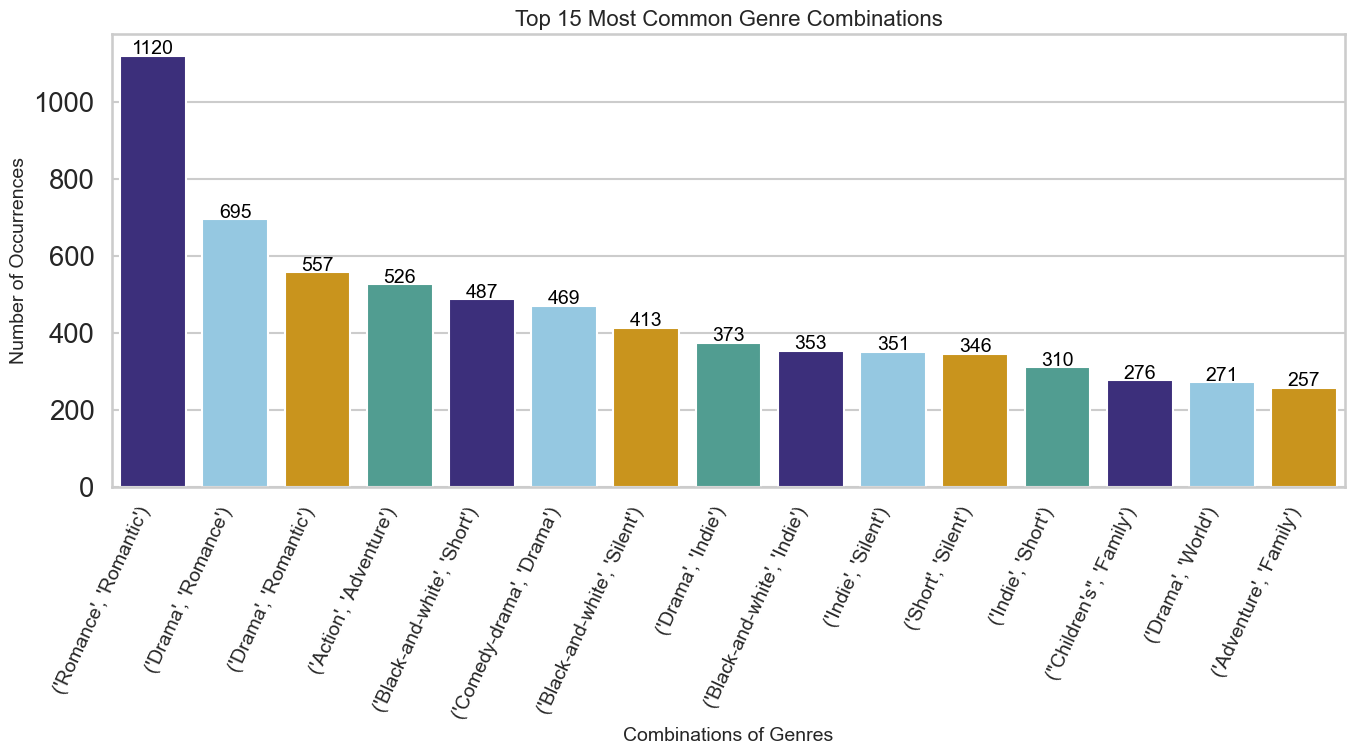

In [193]:
# Sélectionner les 15 combinaisons les plus fréquentes
final_df['combinations'] = final_df['combinations'].astype(str)
top_15_combinations = final_df.head(15)

# Créer l'histogramme
# Définir la taille et le style de la figure
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")  # Appliquer un style esthétique
sns.set_context("talk", font_scale=1.2)  # Ajuster le contexte global et la taille de la police


# Création du barplot
ax = sns.barplot(
    data=top_15_combinations,
    x='combinations',
    y='nombredoccurrence',
    palette=custom_palette
)


# Ajouter les valeurs sur chaque barre
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=14, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Ajuster les labels
plt.xticks(rotation=65, ha='right', fontsize=14)
plt.xlabel('Combinations of Genres', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.title('Top 15 Most Common Genre Combinations', fontsize=16)
plt.tight_layout()

plt.savefig(path_plots_save + "top_genre_combinations.png", dpi=300, bbox_inches='tight')
# Afficher le graphique
plt.show()

In [242]:
df = final_df
df

,combinations,nombredoccurrence,audienceScoremoyenne,tomatoMetermoyen
0,"('Romance', 'Romantic')",1120,57.308057,53.315917
1,"('Drama', 'Romance')",695,59.531447,59.590062
2,"('Drama', 'Romantic')",557,59.925000,58.866180
3,"('Action', 'Adventure')",526,53.332665,45.586842
4,"('Black-and-white', 'Short')",487,55.083582,61.983740
...,...,...,...,...
3734,"('Short', 'War')",1,71.000000,NaN
3735,"('Comedy', 'History')",1,45.000000,25.000000
3736,"('Christmas', 'Thriller')",1,62.000000,35.000000
3737,"('Comedy', 'Hip')",1,54.000000,31.000000


In [250]:
N = 20

# Étape 1 : Nettoyer les genres et extraire tous les genres uniques dans les combinaisons
def clean_genres(genre_string):
    # Nettoie les caractères indésirables comme les guillemets et les parenthèses
    return [re.sub(r"[\'\(\)\[\]]", "", genre).strip() for genre in genre_string.split(', ')]

# Extraire et nettoyer les genres uniques
genres = []
for combo in df['combinations']:
    combo_clean = clean_genres(combo)
    genre1 = combo_clean [0]
    genre2 = combo_clean [1]

    if genre1 not in genres:
        genres.append(genre1)
    if genre2 not in genres:
        genres.append(genre2)

    if len(genres) > N:
        break


    


print(genres)
# Sélectionner les 20 premiers genres uniques (N=20)
top_20_genres = genres[:N]  # Limiter à 20 genres (ou tout autre nombre N)


# Étape 2 : Créer une matrice vide pour les genres
genre_matrix = pd.DataFrame(0, index=top_20_genres, columns=top_20_genres)


['Romance', 'Romantic', 'Drama', 'Action', 'Adventure', 'Black-and-white', 'Short', 'Comedy-drama', 'Silent', 'Indie', '"Childrens"', 'Family', 'World', 'Animation', 'Crime', 'Musical', 'Black', 'Fantasy', 'Thriller', 'Film', 'Comedy']


In [251]:
# Étape 3 : Remplir la matrice avec les fréquences des combinaisons
for combo, count in zip(df['combinations'], df['nombredoccurrence']):
    genres_in_combo = clean_genres(combo)
    
    # Ne conserver que les genres qui figurent dans le top_20_genres
    genres_in_combo = [genre for genre in genres_in_combo if genre in top_20_genres]

    # Vérifier que genres_in_combo contient plus d'un genre, sinon ignorer cette combinaison
    if len(genres_in_combo) > 1:
        # Créer une matrice symétrique des combinaisons (genre1, genre2)
        for i in range(len(genres_in_combo)):
            for j in range(i + 1, len(genres_in_combo)):
                genre1, genre2 = sorted([genres_in_combo[i], genres_in_combo[j]])

                # Vérifier si la combinaison (genre1, genre2) existe, sinon (genre2, genre1)
                if genre_matrix.loc[genre1, genre2] == 0:
                    genre_matrix.loc[genre1, genre2] = count
                else:
                    genre_matrix.loc[genre2, genre1] = count

                # Assurer la symétrie (genre1, genre2) == (genre2, genre1)
                genre_matrix.loc[genre2, genre1] = genre_matrix.loc[genre1, genre2]  # Assurer la symétrie


In [290]:
print(np.nanmin(genre_matrix.values[~np.isnan(genre_matrix.values)]))

0.0


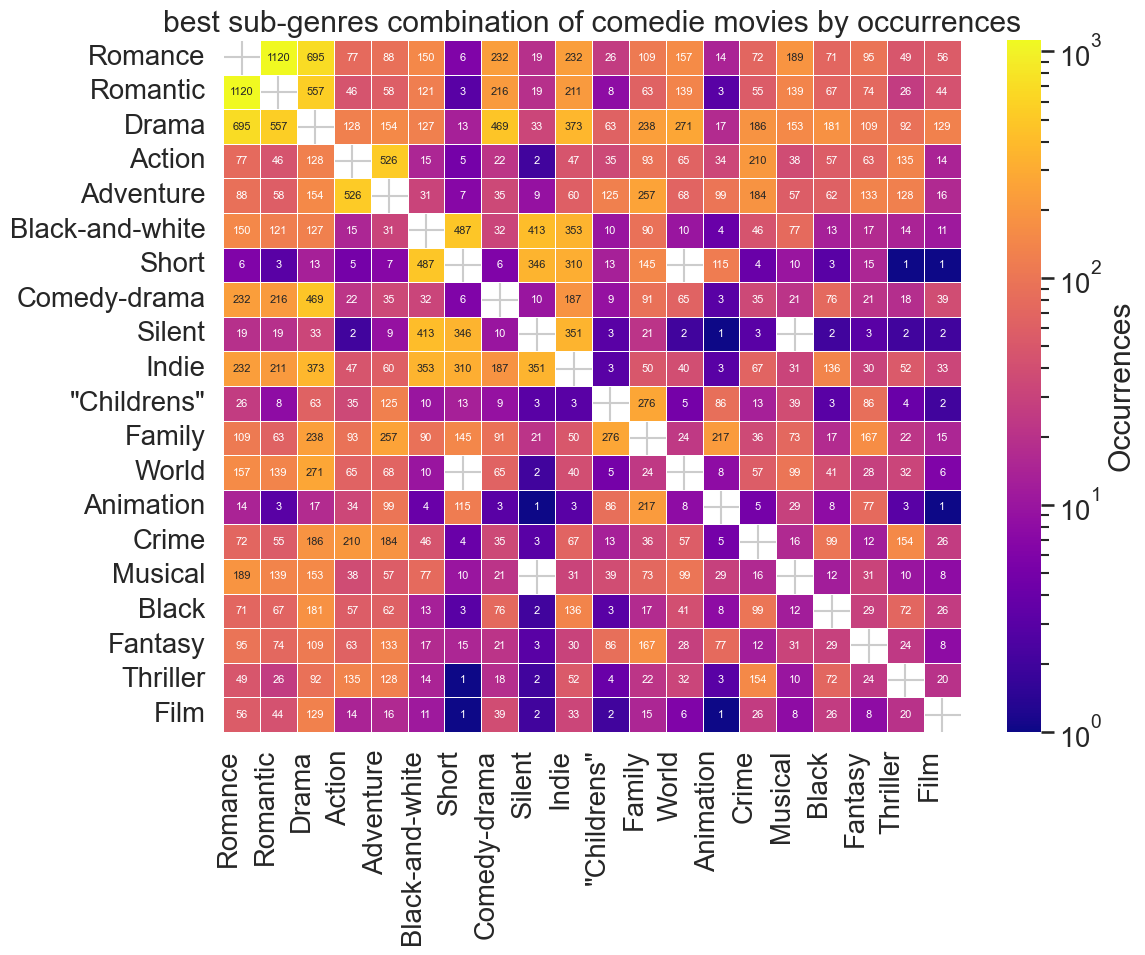

In [311]:
from matplotlib.colors import LogNorm
# # Étape 4 : Vider les cases pour les combinaisons (genre, genre)
# for genre in top_20_genres:
#     genre_matrix.loc[genre, genre] = None  # On remplace par NaN pour les combinaisons (genre, genre)




# print(np.nanmax(genre_matrix.values))



# # Appliquer une échelle logarithmique uniquement pour la coloration (mais pas pour les valeurs)
# plt.figure(figsize=(12, 10))

# # Créer la heatmap en utilisant LogNorm pour l'échelle des couleurs
# sns.heatmap(genre_matrix, annot=True, cmap='viridis', linewidths=0.5, fmt='.0f', 
#             cbar_kws={'label': 'Occurrences'},
#             norm=LogNorm(vmin = np.nanmin(genre_matrix.values)+(1), vmax= np.nanmax(genre_matrix.values)),  # Appliquer LogNorm
#             mask=genre_matrix.isna(), annot_kws={'size': 8})

# # Ajouter un titre et ajuster les étiquettes
# plt.title('Heatmap des combinaisons de genres (échelle logarithmique pour la coloration)')
# plt.xticks(rotation=90, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()



# Remplacer les NaN par 0 pour les afficher en blanc
genre_matrix_filled = genre_matrix.fillna(0)

# Créer un masque où les valeurs sont égales à 0
zero_mask = genre_matrix_filled == 0

# Appliquer une échelle logarithmique, mais ignorer les 0 dans l'échelle des couleurs
plt.figure(figsize=(12, 10))

# Créer la heatmap avec une échelle logarithmique, mais afficher les 0 en blanc
sns.heatmap(genre_matrix_filled, annot=True, cmap='plasma', linewidths=0.5, fmt='.0f', 
            cbar_kws={'label': 'Occurrences'},
            norm=LogNorm(vmin=np.nanmin(genre_matrix.values[~np.isnan(genre_matrix.values)]+1), 
                         vmax=np.nanmax(genre_matrix.values[~np.isnan(genre_matrix.values)])),  # Appliquer LogNorm uniquement aux valeurs non-NaN
            mask=zero_mask,  # Masquer les 0
            annot_kws={'size': 8})

# Ajouter un titre et ajuster les étiquettes
plt.title('best sub-genres combination of comedie movies by occurrences')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(path_plots_save + "heatmap_nombre_apparition_combinaisons_genre.png", dpi=300, bbox_inches='tight')
plt.show()

In [312]:
df_sort_public_score = df.sort_values(by='audienceScoremoyenne', ascending=False)

# Réinitialiser les index après le tri (optionnel)
df_sort_public_score = df_sort_public_score.reset_index(drop=True)
df_sort_public_score


,combinations,nombredoccurrence,audienceScoremoyenne,tomatoMetermoyen
0,"('Avant-garde', 'Time')",1,100.0,NaN
1,"('Black-and-white', 'Zombie')",1,100.0,NaN
2,"('Experimental', 'Time')",1,100.0,NaN
3,"('Comedy', 'Experimental')",1,100.0,NaN
4,"('Animated', 'Fairy')",1,100.0,NaN
...,...,...,...,...
3734,"('Action', 'Indian')",1,NaN,NaN
3735,"('Period', 'Western')",1,NaN,NaN
3736,"('Political', 'Social')",1,NaN,NaN
3737,"('Period', 'Television')",1,NaN,NaN


In [329]:
# Supprimer les lignes où 'audienceScoremoyenne' ou 'tomatoMetermoyen' est NaN
df_sort_public_score = df_sort_public_score.dropna(subset=['audienceScoremoyenne', 'tomatoMetermoyen'])
df_sort_public_score = df_sort_public_score.reset_index(drop=True)
# Afficher le DataFrame nettoyé
df_sort_public_score.head(40)

,combinations,nombredoccurrence,audienceScoremoyenne,tomatoMetermoyen
0,"('Slasher', 'World')",1,97.0,88.0
1,"('Chinese', 'Slasher')",1,97.0,88.0
2,"('Absurdism', 'Costume')",1,95.0,98.0
3,"('Action', 'Humour')",1,95.0,98.0
4,"('Cult', 'Humour')",1,95.0,98.0
5,"('Absurdism', 'Humour')",1,95.0,98.0
6,"('Costume', 'Humour')",1,95.0,98.0
7,"('Humour', 'Parody')",1,95.0,98.0
8,"('Humour', 'Slapstick')",1,95.0,98.0
9,"('History', 'Musical')",2,94.0,88.0


In [357]:
# Liste de genres à supprimer
genres_to_remove = ['Slasher', 'New', 'Pre-Code', 'Humour', 'History', 'Hybrid', 'Existentialism', 'Addiction', 'Gay', 'Costume', 'Childhood', 'Melodrama', 'Neo-noir', 'Computer', 'Fairy', 'Kafkaesque', 'Future', 'Educational' ]

# Fonction pour vérifier si l'un des genres à supprimer est dans la combinaison
def contains_genre(combo, genres_to_remove):
    return any(genre in combo for genre in genres_to_remove)

# Supprimer les lignes contenant les genres de la liste dans 'combinations'
df_sort_public_score = df_sort_public_score[~df_sort_public_score['combinations'].apply(lambda x: contains_genre(x, genres_to_remove))]

df_sort_public_score = df_sort_public_score.reset_index(drop=True)
# Afficher le DataFrame nettoyé
df_sort_public_score.head(20)



,combinations,nombredoccurrence,audienceScoremoyenne,tomatoMetermoyen
0,"('Black-and-white', 'Road')",2,93.5,95.5
1,"('Avant-garde', 'Western')",1,93.0,30.0
2,"('Experimental', 'Western')",1,93.0,30.0
3,"('Feminist', 'World')",1,93.0,98.0
4,"('Experimental', 'LGBT')",1,93.0,30.0
5,"('Avant-garde', 'LGBT')",1,93.0,30.0
6,"('Black-and-white', 'Domestic')",3,93.0,100.0
7,"('Crime', 'Stop')",1,92.0,100.0
8,"('Period', 'Stoner')",1,92.0,83.0
9,"('B-movie', 'LGBT')",1,92.0,97.0


In [358]:
N = 20

# Étape 1 : Nettoyer les genres et extraire tous les genres uniques dans les combinaisons
def clean_genres(genre_string):
    # Nettoie les caractères indésirables comme les guillemets et les parenthèses
    return [re.sub(r"[\'\(\)\[\]]", "", genre).strip() for genre in genre_string.split(', ')]

# Extraire et nettoyer les genres uniques
genres = []
for combo in df_sort_public_score['combinations']:
    combo_clean = clean_genres(combo)
    genre1 = combo_clean [0]
    genre2 = combo_clean [1]

    if genre1 not in genres:
        genres.append(genre1)
    if genre2 not in genres:
        genres.append(genre2)

    if len(genres) > N:
        break


top_20_genres = genres[:N]  # Limiter à 20 genres (ou tout autre nombre N)


# Étape 2 : Créer une matrice vide pour les genres
genre_matrix = pd.DataFrame(0, index=top_20_genres, columns=top_20_genres)

# Étape 3 : Remplir la matrice avec les fréquences des combinaisons
for combo, count in zip(df['combinations'], df['audienceScoremoyenne']):
    genres_in_combo = clean_genres(combo)
    
    # Ne conserver que les genres qui figurent dans le top_20_genres
    genres_in_combo = [genre for genre in genres_in_combo if genre in top_20_genres]

    # Vérifier que genres_in_combo contient plus d'un genre, sinon ignorer cette combinaison
    if len(genres_in_combo) > 1:
        # Créer une matrice symétrique des combinaisons (genre1, genre2)
        for i in range(len(genres_in_combo)):
            for j in range(i + 1, len(genres_in_combo)):
                genre1, genre2 = sorted([genres_in_combo[i], genres_in_combo[j]])

                # Vérifier si la combinaison (genre1, genre2) existe, sinon (genre2, genre1)
                if genre_matrix.loc[genre1, genre2] == 0:
                    genre_matrix.loc[genre1, genre2] = count
                else:
                    genre_matrix.loc[genre2, genre1] = count

                # Assurer la symétrie (genre1, genre2) == (genre2, genre1)
                genre_matrix.loc[genre2, genre1] = genre_matrix.loc[genre1, genre2]  # Assurer la symétrie

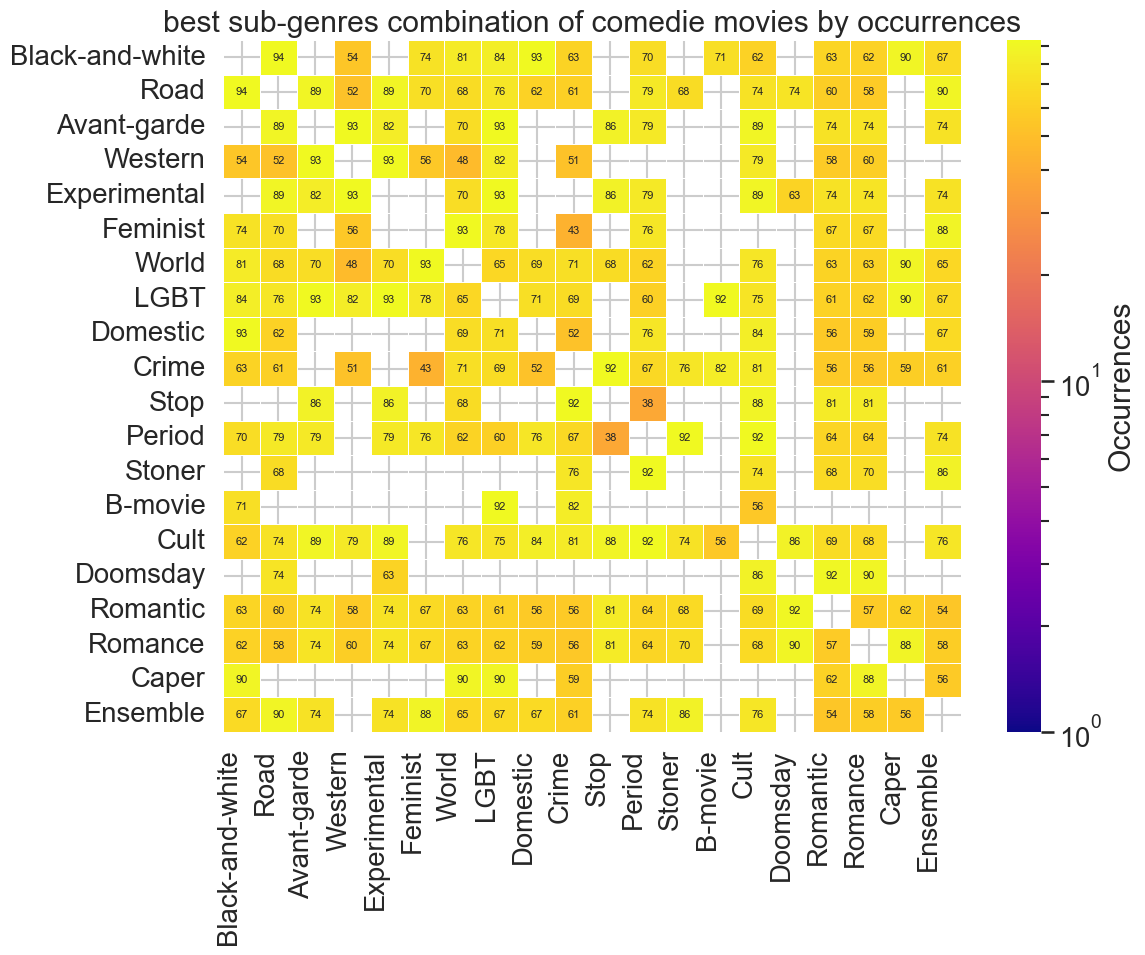

In [359]:
# Remplacer les NaN par 0 pour les afficher en blanc


# Créer un masque où les valeurs sont égales à 0
# Remplacer les NaN par 0 pour les afficher en blanc
genre_matrix_filled = genre_matrix.fillna(0)

# Créer un masque où les valeurs sont égales à 0
zero_mask = genre_matrix_filled == 0

# Appliquer une échelle logarithmique, mais ignorer les 0 dans l'échelle des couleurs
plt.figure(figsize=(12, 10))

# Créer la heatmap avec une échelle logarithmique, mais afficher les 0 en blanc
sns.heatmap(genre_matrix_filled, annot=True, cmap='plasma', linewidths=0.5, fmt='.0f', 
            cbar_kws={'label': 'Occurrences'},
            norm=LogNorm(vmin=np.nanmin(genre_matrix.values[~np.isnan(genre_matrix.values)]+1), 
                         vmax=np.nanmax(genre_matrix.values[~np.isnan(genre_matrix.values)])),  # Appliquer LogNorm uniquement aux valeurs non-NaN
            mask=zero_mask,  # Masquer les 0
            annot_kws={'size': 8})

# Ajouter un titre et ajuster les étiquettes
plt.title('best sub-genres combination of comedie movies by occurrences')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(path_plots_save + "heatmap_nombre_apparition_combinaisons_genre.png", dpi=300, bbox_inches='tight')
plt.show()